In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import lxml

In [408]:
#Loading Bilbao Open Data about districts
url = 'http://www.bilbao.eus/bilbaoopendata/demografia/numero_habitantes_distrito_sexo_2019.csv'
bildf = pd.read_csv(
    filepath_or_buffer='bilbao habitantes.csv',encoding='ISO-8859-1')
bildf

,DISTRITO;HOMBRES;MUJERES;TOTAL
0,01 DEUSTU;22950;26243;49193
1,02 URIBARRI;16813;19334;36147
2,03 OTXARKOAGA - TXURDINAGA;12344;13362;25706
3,04 BEGOÑA;18937;21626;40563
4,05 IBAIONDO;30770;31849;62619
5,06 ABANDO;23198;28309;51507
6,07 ERREKALDE;23267;25532;48799
7,08 BASURTU - ZORROTZA;15343;17206;32549
8,GUZTIRA / TOTAL BILBAO;163622;183461;347083


In [409]:
#Splitting info
bildf['Neighborhood'] = bildf['DISTRITO;HOMBRES;MUJERES;TOTAL'].str.split(';').str[-0]
bildf['Totalhab'] = bildf['DISTRITO;HOMBRES;MUJERES;TOTAL'].str.split(';').str[-1]
bildf = bildf.drop('DISTRITO;HOMBRES;MUJERES;TOTAL', axis=1)
bildf = bildf.drop(bildf.index[8])
bildf['Neighborhood'] = bildf['Neighborhood'].str.split(' ').str[1]
bildf

,Neighborhood,Totalhab
0,DEUSTU,49193
1,URIBARRI,36147
2,OTXARKOAGA,25706
3,BEGOÑA,40563
4,IBAIONDO,62619
5,ABANDO,51507
6,ERREKALDE,48799
7,BASURTU,32549


In [410]:
#Adding Latitude and Longitude with Geocoder Nominatim
from geopy.geocoders import Nominatim
geolocator = Nominatim()
bildf['Coordinates']= bildf['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
bildf[['Latitude', 'Longitude']] = bildf['Coordinates'].apply(pd.Series)

bildf.drop(['Coordinates'], axis=1, inplace=True)

bildf

/Users/Alberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Totalhab,Latitude,Longitude
0,DEUSTU,49193,43.271387,-2.949581
1,URIBARRI,36147,42.991078,-2.615515
2,OTXARKOAGA,25706,43.259411,-2.897683
3,BEGOÑA,40563,40.480207,-3.685955
4,IBAIONDO,62619,43.239543,-2.929882
5,ABANDO,51507,43.262788,-2.934947
6,ERREKALDE,48799,42.869074,-2.229884
7,BASURTU,32549,43.261691,-2.960225


In [411]:
#Replacing wrong coordinates for right ones from Uribarri, Errekalde and Begoña
bildf['Latitude'][1] = 43.271857
bildf['Longitude'][1] = -2.918756
#Begoña
bildf['Latitude'][3] = 43.252068
bildf['Longitude'][3] = -2.912713
#Errekalde
bildf['Latitude'][6] = 43.238485
bildf['Longitude'][6] = -2.954978

/Users/Alberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Alberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Alberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/Alberto/anaconda3/lib/pyth

In [412]:
#Checking correction
bildf

,Neighborhood,Totalhab,Latitude,Longitude
0,DEUSTU,49193,43.271387,-2.949581
1,URIBARRI,36147,43.271857,-2.918756
2,OTXARKOAGA,25706,43.259411,-2.897683
3,BEGOÑA,40563,43.252068,-2.912713
4,IBAIONDO,62619,43.239543,-2.929882
5,ABANDO,51507,43.262788,-2.934947
6,ERREKALDE,48799,43.238485,-2.954978
7,BASURTU,32549,43.261691,-2.960225


In [413]:
#Coordinates from Bilbao

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Bilbao'

geolocator = Nominatim(user_agent="Bilbao_explorer")
location = geolocator.geocode(address)
Bilbao_latitude = location.latitude
Bilbao_longitude = location.longitude
print('The geograpical coordinates of Bilbao are {}, {}.'.format(Bilbao_latitude, Bilbao_longitude))

The geograpical coordinates of Bilbao are 43.2630051, -2.9349915.


In [414]:
# Map from Bilbao
Bilbaom = folium.Map(location=[Bilbao_latitude, Bilbao_longitude], zoom_start=12)

# Adding markers to each district
for lat, lng, metro in zip(bildf['Latitude'], bildf['Longitude'], bildf['Neighborhood']):
    label = '{}'.format(metro)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Bilbaom)  
    
Bilbaom

In [415]:
#Function to add business markers and coordinates
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=3000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):

            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                                       CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            response = requests.get(url).json()
            results = response["response"]['venues']
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [416]:
# Exploring with Foursquare API
CLIENT_ID = 'AV2RXHWVXPVA2W4UAFKRNVMEINKR3U2RAQYF2XBVARV3U0PG' # your Foursquare ID
CLIENT_SECRET = 'PJIWCB43CE1JXMLIXKSCVWNOQ2HM130004DB0KOQX5MHHXEB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AV2RXHWVXPVA2W4UAFKRNVMEINKR3U2RAQYF2XBVARV3U0PG
CLIENT_SECRET:PJIWCB43CE1JXMLIXKSCVWNOQ2HM130004DB0KOQX5MHHXEB


In [417]:
#pip install urllib3

In [418]:
#Best Bilbao Venues
Bilbaovenues = getNearbyVenues(names=bildf['Neighborhood'], latitudes=bildf['Latitude'], longitudes=bildf['Longitude'], 
                                  radius=3000)
Bilbaovenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,DEUSTU,43.271387,-2.949581,Metro Deusto,43.272036,-2.948452,Metro Station
1,DEUSTU,43.271387,-2.949581,Telepizza,43.271436,-2.949716,Pizza Place
2,DEUSTU,43.271387,-2.949581,Metro San Mamés,43.262399,-2.947941,Metro Station
3,DEUSTU,43.271387,-2.949581,Tegobi,43.261963,-2.924559,Beer Bar
4,DEUSTU,43.271387,-2.949581,Golf Barri,43.271381,-2.949789,Breakfast Spot


In [419]:
#Bilbao Venues Categories
Bilbaovenues['Venue Category'].unique()[:50]

array(['Metro Station', 'Pizza Place', 'Beer Bar', 'Breakfast Spot',
       'Bank', 'Plaza', 'Fried Chicken Joint', 'Shopping Mall',
       'Department Store', 'Café', 'Museum', 'American Restaurant', 'Bar',
       'Building', 'Laundry Service', 'Coffee Shop',
       'Residential Building (Apartment / Condo)', 'Restaurant', 'Diner',
       "Doctor's Office", 'Government Building', 'Business Center',
       'Spanish Restaurant', 'Nail Salon', 'Food & Drink Shop',
       'Hardware Store', 'Gift Shop', 'Vacation Rental',
       'Lottery Retailer', 'Automotive Shop', 'Bakery', 'Optical Shop',
       'Pet Store', 'Medical Supply Store', 'Bike Rental / Bike Share',
       'Travel Agency', 'Bus Line', 'Financial or Legal Service',
       'Snack Place', 'Cosmetics Shop', 'Middle Eastern Restaurant',
       'Convenience Store', 'Food', 'Burger Joint', 'Hostel',
       'Candy Store', 'Fish Market', 'Gym / Fitness Center', 'Library',
       'Spa'], dtype=object)

In [420]:
#Groupby Venue Category
Bilbaovn = Bilbaovenues.groupby('Venue Category').count()
Bilbaovn.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,3,3,3,3,3,3
American Restaurant,1,1,1,1,1,1
Antique Shop,1,1,1,1,1,1
Arcade,1,1,1,1,1,1
Arts & Crafts Store,2,2,2,2,2,2


In [421]:
#Saving to CSV
Bilbaovn = Bilbaovn.reindex(columns=['Neighborhood'])
Bilbaovn = Bilbaovn.sort_values(by=['Neighborhood'], ascending=False).head(20)
Bilbaovn.to_csv('Bilbaovn.csv')

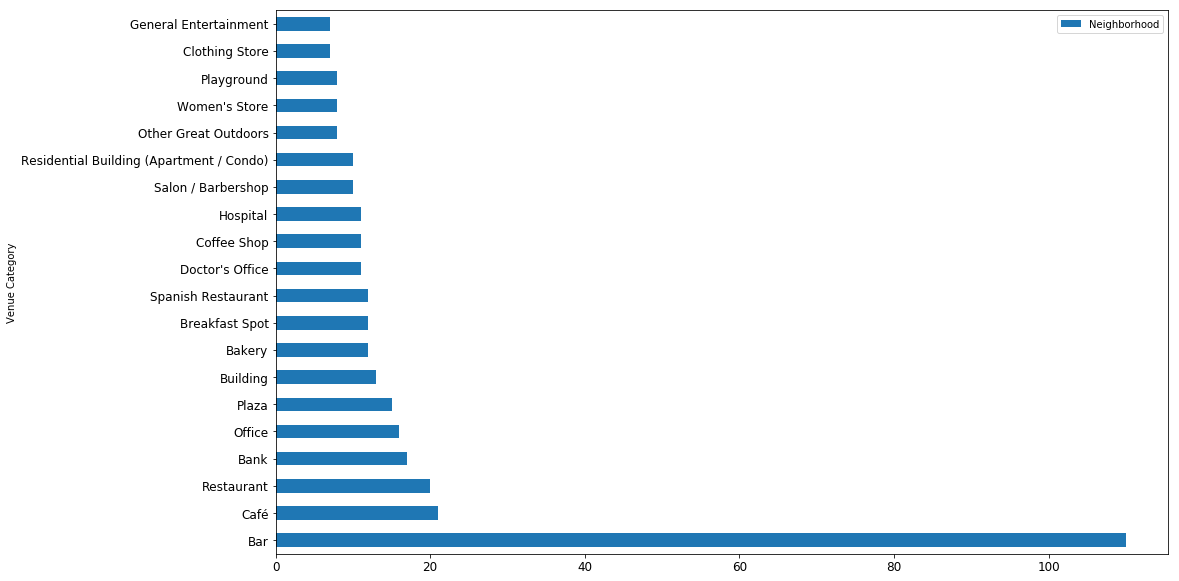

In [422]:
#Bar graph
Bilbaovn_bar = pd.read_csv('Bilbaovn.csv')
Bilbaovn_bar.plot.barh(x='Venue Category',fontsize = 12, figsize=(16, 10),stacked=True);

In [423]:
#One hot encoding
Bil_onehot = pd.get_dummies(Bilbaovenues[['Venue Category']], prefix="", prefix_sep="")

#Add neighborhood column back to dataframe
Bil_onehot['Neighborhood'] = Bilbaovenues['Neighborhood'] 

#Move neighborhood column to the first column
fixed_columns = [Bil_onehot.columns[-1]] + list(Bil_onehot.columns[:-1])
Bil_onehot.head()

,Accessories Store,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Automotive Shop,...,Vacation Rental,Veterinarian,Video Game Store,Voting Booth,Warehouse,Water Park,Wine Bar,Winery,Women's Store,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DEUSTU
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DEUSTU
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DEUSTU
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DEUSTU
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DEUSTU


In [424]:
#Bilbao Grouped
Bilbao_grouped=Bil_onehot.groupby('Neighborhood').mean().reset_index()
Bilbao_grouped

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,...,Urgent Care Center,Vacation Rental,Veterinarian,Video Game Store,Voting Booth,Warehouse,Water Park,Wine Bar,Winery,Women's Store
0,ABANDO,0.032967,0.000000,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010989,0.000000,0.00000,0.000000,0.000000,0.000000,0.087912
1,BASURTU,0.000000,0.000000,0.010309,0.010309,0.000000,0.010309,0.000000,0.000000,0.010309,...,0.010309,0.000000,0.000000,0.000000,0.000000,0.00000,0.010309,0.000000,0.000000,0.000000
2,BEGOÑA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010526,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.021053,0.010526,0.000000
3,DEUSTU,0.000000,0.010204,0.000000,0.000000,0.010204,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010204,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,ERREKALDE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010309,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.010309,0.000000,0.000000
5,IBAIONDO,0.000000,0.000000,0.000000,0.000000,0.010870,0.000000,0.000000,0.000000,0.010870,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.01087,0.000000,0.010870,0.000000,0.000000
6,OTXARKOAGA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.011111,0.000000,...,0.000000,0.000000,0.011111,0.000000,0.011111,0.00000,0.000000,0.000000,0.000000,0.000000
7,URIBARRI,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010526,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.010526,0.000000,0.000000


In [425]:
#Top 5 Bilbao Venus
num_top_venues = 5


for hood in Bilbao_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Bilbao_grouped[Bilbao_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ABANDO----
            venue  freq
0   Women's Store  0.09
1  Clothing Store  0.07
2            Bank  0.05
3      Restaurant  0.03
4           Hotel  0.03


----BASURTU----
         venue  freq
0     Hospital  0.11
1       Office  0.06
2      Brewery  0.04
3     Building  0.04
4  Music Venue  0.03


----BEGOÑA----
          venue  freq
0           Bar  0.27
1   Coffee Shop  0.04
2    Playground  0.03
3    Restaurant  0.03
4  Optical Shop  0.03


----DEUSTU----
                                      venue  freq
0                                       Bar  0.11
1  Residential Building (Apartment / Condo)  0.04
2                                      Café  0.04
3                                      Bank  0.04
4                            Breakfast Spot  0.03


----ERREKALDE----
                  venue  freq
0                   Bar  0.27
1               Butcher  0.03
2         Grocery Store  0.03
3                Bakery  0.03
4  Other Great Outdoors  0.03


----IBAIONDO----
            

In [426]:
#Function Most Common Venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [427]:
#Setting Bilbao Num Top Venues
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

#Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#Create a new Bilbao dataframe
Bilbao_distr_ord = pd.DataFrame(columns=columns)
Bilbao_distr_ord['Neighborhood'] = Bilbao_grouped['Neighborhood']

for ind in np.arange(Bilbao_grouped.shape[0]):
    Bilbao_distr_ord.iloc[ind, 1:] = return_most_common_venues(Bilbao_grouped.iloc[ind, :], num_top_venues)

Bilbao_distr_ord

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABANDO,Women's Store,Clothing Store,Bank,Restaurant,Boutique,Dessert Shop,Hotel,Accessories Store,Hotel Bar,Café
1,BASURTU,Hospital,Office,Building,Brewery,Music Venue,Restaurant,BBQ Joint,Coworking Space,Doctor's Office,Café
2,BEGOÑA,Bar,Coffee Shop,Restaurant,Playground,Plaza,Optical Shop,Café,Gift Shop,Snack Place,Salon / Barbershop
3,DEUSTU,Bar,Bank,Residential Building (Apartment / Condo),Café,Breakfast Spot,Shopping Mall,Spanish Restaurant,Plaza,Coffee Shop,Automotive Shop
4,ERREKALDE,Bar,Bakery,Butcher,Other Great Outdoors,Grocery Store,Convenience Store,Restaurant,Breakfast Spot,Residential Building (Apartment / Condo),Spanish Restaurant
5,IBAIONDO,Bar,Bank,Office,Salon / Barbershop,Doctor's Office,Dentist's Office,Bus Stop,Bus Line,Kebab Restaurant,Bakery
6,OTXARKOAGA,Bar,Café,General Entertainment,Bank,Police Station,Student Center,Salon / Barbershop,Dessert Shop,Bike Rental / Bike Share,Bakery
7,URIBARRI,Bar,Restaurant,Diner,Plaza,Playground,Spanish Restaurant,Other Great Outdoors,Supermarket,Office,Café


In [428]:
#KMEANS
#Set the number of clusters
kclusters = 5

Bilbao_distr_clustering = Bilbao_grouped.drop('Neighborhood', 1)

#Run K-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Bilbao_distr_clustering)

#Check cluster labels generated for each row in the dataframe
kmeans.labels_ 
#to change use .astype()

array([3, 2, 0, 1, 0, 0, 1, 4], dtype=int32)

In [429]:
#Add clustering labels
Bilbao_distr_ord.insert(0, 'Cluster_Labels', kmeans.labels_)
Bilbao_distr_ord.head()

,Cluster_Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,ABANDO,Women's Store,Clothing Store,Bank,Restaurant,Boutique,Dessert Shop,Hotel,Accessories Store,Hotel Bar,Café
1,2,BASURTU,Hospital,Office,Building,Brewery,Music Venue,Restaurant,BBQ Joint,Coworking Space,Doctor's Office,Café
2,0,BEGOÑA,Bar,Coffee Shop,Restaurant,Playground,Plaza,Optical Shop,Café,Gift Shop,Snack Place,Salon / Barbershop
3,1,DEUSTU,Bar,Bank,Residential Building (Apartment / Condo),Café,Breakfast Spot,Shopping Mall,Spanish Restaurant,Plaza,Coffee Shop,Automotive Shop
4,0,ERREKALDE,Bar,Bakery,Butcher,Other Great Outdoors,Grocery Store,Convenience Store,Restaurant,Breakfast Spot,Residential Building (Apartment / Condo),Spanish Restaurant


In [431]:
Bilbao_merged = bildf

#Merge Bilbao_grouped with Bilbao_data to add latitude/longitude for each neighborhood
Bilbao_merged = Bilbao_merged.join(Bilbao_distr_ord.set_index('Neighborhood'), on='Neighborhood')

Bilbao_merged.head()

,Neighborhood,Totalhab,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DEUSTU,49193,43.271387,-2.949581,1,Bar,Bank,Residential Building (Apartment / Condo),Café,Breakfast Spot,Shopping Mall,Spanish Restaurant,Plaza,Coffee Shop,Automotive Shop
1,URIBARRI,36147,43.271857,-2.918756,4,Bar,Restaurant,Diner,Plaza,Playground,Spanish Restaurant,Other Great Outdoors,Supermarket,Office,Café
2,OTXARKOAGA,25706,43.259411,-2.897683,1,Bar,Café,General Entertainment,Bank,Police Station,Student Center,Salon / Barbershop,Dessert Shop,Bike Rental / Bike Share,Bakery
3,BEGOÑA,40563,43.252068,-2.912713,0,Bar,Coffee Shop,Restaurant,Playground,Plaza,Optical Shop,Café,Gift Shop,Snack Place,Salon / Barbershop
4,IBAIONDO,62619,43.239543,-2.929882,0,Bar,Bank,Office,Salon / Barbershop,Doctor's Office,Dentist's Office,Bus Stop,Bus Line,Kebab Restaurant,Bakery


In [432]:
Bilbao_merged=Bilbao_merged.dropna()

In [433]:
Bilbao_merged['Cluster_Labels'] = Bilbao_merged.Cluster_Labels.astype(int)
Bilbao_merged.head(10)

,Neighborhood,Totalhab,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DEUSTU,49193,43.271387,-2.949581,1,Bar,Bank,Residential Building (Apartment / Condo),Café,Breakfast Spot,Shopping Mall,Spanish Restaurant,Plaza,Coffee Shop,Automotive Shop
1,URIBARRI,36147,43.271857,-2.918756,4,Bar,Restaurant,Diner,Plaza,Playground,Spanish Restaurant,Other Great Outdoors,Supermarket,Office,Café
2,OTXARKOAGA,25706,43.259411,-2.897683,1,Bar,Café,General Entertainment,Bank,Police Station,Student Center,Salon / Barbershop,Dessert Shop,Bike Rental / Bike Share,Bakery
3,BEGOÑA,40563,43.252068,-2.912713,0,Bar,Coffee Shop,Restaurant,Playground,Plaza,Optical Shop,Café,Gift Shop,Snack Place,Salon / Barbershop
4,IBAIONDO,62619,43.239543,-2.929882,0,Bar,Bank,Office,Salon / Barbershop,Doctor's Office,Dentist's Office,Bus Stop,Bus Line,Kebab Restaurant,Bakery
5,ABANDO,51507,43.262788,-2.934947,3,Women's Store,Clothing Store,Bank,Restaurant,Boutique,Dessert Shop,Hotel,Accessories Store,Hotel Bar,Café
6,ERREKALDE,48799,43.238485,-2.954978,0,Bar,Bakery,Butcher,Other Great Outdoors,Grocery Store,Convenience Store,Restaurant,Breakfast Spot,Residential Building (Apartment / Condo),Spanish Restaurant
7,BASURTU,32549,43.261691,-2.960225,2,Hospital,Office,Building,Brewery,Music Venue,Restaurant,BBQ Joint,Coworking Space,Doctor's Office,Café


In [435]:
#Final Bilbao map
map_clusters = folium.Map(location=[Bilbao_latitude, Bilbao_longitude], zoom_start=13)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Bilbao_merged['Latitude'], Bilbao_merged['Longitude'], Bilbao_merged['Neighborhood'], Bilbao_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [436]:
#Save the map as HTML file
map_clusters.save('map_clusters.html')

In [437]:
#Cluster 1
Bilbao_merged.loc[Bilbao_merged['Cluster_Labels'] == 0, Bilbao_merged.columns[[0] + list(range(5, Bilbao_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,BEGOÑA,Bar,Coffee Shop,Restaurant,Playground,Plaza,Optical Shop,Café,Gift Shop,Snack Place,Salon / Barbershop
4,IBAIONDO,Bar,Bank,Office,Salon / Barbershop,Doctor's Office,Dentist's Office,Bus Stop,Bus Line,Kebab Restaurant,Bakery
6,ERREKALDE,Bar,Bakery,Butcher,Other Great Outdoors,Grocery Store,Convenience Store,Restaurant,Breakfast Spot,Residential Building (Apartment / Condo),Spanish Restaurant


In [438]:
#Cluster 2
Bilbao_merged.loc[Bilbao_merged['Cluster_Labels'] == 1, Bilbao_merged.columns[[0] + list(range(5, Bilbao_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DEUSTU,Bar,Bank,Residential Building (Apartment / Condo),Café,Breakfast Spot,Shopping Mall,Spanish Restaurant,Plaza,Coffee Shop,Automotive Shop
2,OTXARKOAGA,Bar,Café,General Entertainment,Bank,Police Station,Student Center,Salon / Barbershop,Dessert Shop,Bike Rental / Bike Share,Bakery


In [439]:
#Cluster 3
Bilbao_merged.loc[Bilbao_merged['Cluster_Labels'] == 2, Bilbao_merged.columns[[0] + list(range(5, Bilbao_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,BASURTU,Hospital,Office,Building,Brewery,Music Venue,Restaurant,BBQ Joint,Coworking Space,Doctor's Office,Café


In [440]:
#Cluster 4
Bilbao_merged.loc[Bilbao_merged['Cluster_Labels'] == 3, Bilbao_merged.columns[[0] + list(range(5, Bilbao_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,ABANDO,Women's Store,Clothing Store,Bank,Restaurant,Boutique,Dessert Shop,Hotel,Accessories Store,Hotel Bar,Café


In [441]:
#Cluster 5
Bilbao_merged.loc[Bilbao_merged['Cluster_Labels'] == 4, Bilbao_merged.columns[[0] + list(range(5, Bilbao_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,URIBARRI,Bar,Restaurant,Diner,Plaza,Playground,Spanish Restaurant,Other Great Outdoors,Supermarket,Office,Café
